## Download, Extraction & Preprocess SVHN Data

In [301]:
# These are all the modules we'll be using later.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import os
import sys
import tarfile
from IPython.display import display, Image

import scipy.io   
import h5py

import matplotlib.pyplot as plt

from PIL import Image
import random

In [302]:
%matplotlib inline

Download dataset 

In [303]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('train.tar.gz', 404141560 )
test_filename = maybe_download('test.tar.gz', 276555967 )

Found and verified train.tar.gz
Found and verified test.tar.gz


Extracting Data

In [304]:
num_classes = 10
np.random.seed(133)

train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
# extra_filename = 'extra.tar.gz'

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    if not os.path.exists(root+'/digitStruct.mat'):
        print("digitStruct.mat is missing")
    return root + '/digitStruct.mat'
  
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


Read and Explore the dataset

In [209]:
print(train_folders)

train/digitStruct.mat


In [210]:
train_dataset = h5py.File(train_folders, "r")

In [211]:
train_dataset["digitStruct"].items()

[(u'bbox', <HDF5 dataset "bbox": shape (33402, 1), type "|O">),
 (u'name', <HDF5 dataset "name": shape (33402, 1), type "|O">)]

In [231]:
train_dataset[train_dataset[bbox[0].item()]["label"].value[1][0]].value

array([[ 9.]])

In [308]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [311]:
train = DigitStructFile(train_folders)
train_data = train.getAllDigitStructure_ByDigit()


test = DigitStructFile(test_folders)
test_data = test.getAllDigitStructure_ByDigit()

In [313]:
train_data[0]

{'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}],
 'filename': '1.png'}

In [315]:
# save digitStruct information 
pickle_file = 'multi_bbox_info.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_data': train_data,
    'test_data': test_data,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [317]:
class Dataset:
    """crop images and save them to numpy ndarray"""
    
    def __init__(self, digitStruct, folder):
        self.digitStruct = digitStruct
        self.folder = folder
        
    def setDataset(self):
        self.dataset = np.ndarray(shape=(len(self.digitStruct), 32, 32), dtype='float32')
        
        # 1 length + 5 labels, 10 represents none
        self.labels = np.ones(shape=(len(self.digitStruct), 6), dtype='int') * 10 
        
    def getDataset(self):
        
        self.setDataset()
        
        for i in range(len(self.digitStruct)):

            fin = os.path.join(self.folder, self.digitStruct[i]['filename'])
            im = Image.open(fin)
            
            boxes = self.digitStruct[i]['boxes']
            
            if len(boxes) > 5:
                print(fin, "has more than 5 digits")
            else:
                self.labels[i,0] = len(boxes)
                self.labels[i,1:len(boxes)+1] = [int(j['label']) for j in boxes]
            
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            
            box = self.img_box(im, left, top, height, width)

            size = (32, 32)
            region = im.crop(box).resize(size)
            region = self.normalization(region)

            self.dataset[i,:,:] = region[:,:] 
            
        print('dataset:',self.dataset.shape)
        print('labels:',self.labels.shape)
        return self.dataset, self.labels
        
    def img_box(self, im, left, top, height, width):

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = min(im.size[1], im_top + im_height * 1.2)
        im_right = min(im.size[0], im_left + im_width * 1.2)

        return (im_left, im_top, im_right, im_bottom)


    def normalization(self, img):
        im = img.convert('L') # RGB to greyscale
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        return (im - mean) / std    
        

In [318]:
train_dataset = Dataset(train_data, 'train')
train_dataset, train_labels = trainDataset.getDataset()


train/29930.png has more than 5 digits
dataset: (33402, 32, 32)
labels: (33402, 6)


NameError: name 'test_datast' is not defined

[10 10 10 10 10 10]


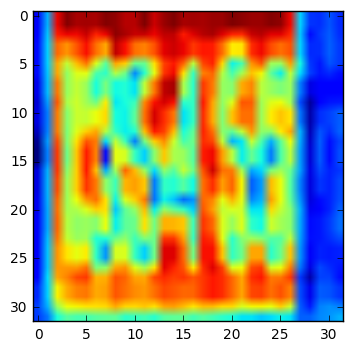

In [323]:
plt.imshow(train_dataset[29929])
print(train_labels[29929])

In [324]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [325]:
print(train_dataset.shape)
print(train_labels.shape)

(33401, 32, 32)
(33401, 6)


In [326]:
test_dataset = Dataset(test_data, 'test')
test_dataset, test_labels = test_dataset.getDataset()

dataset: (13068, 32, 32)
labels: (13068, 6)


In [329]:
train_portion = 6000
valid_dataset = train_dataset[:train_portion,:,:]
valid_labels = train_labels[:train_portion]
train_dataset = train_dataset[train_portion:,:,:]
train_labels = train_labels[train_portion:]
                             
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(27401, 32, 32) (27401, 6)
(13068, 32, 32) (13068, 6)
(6000, 32, 32) (6000, 6)


In [330]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [331]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i][1:5])
        plt.imshow(dataset[i])

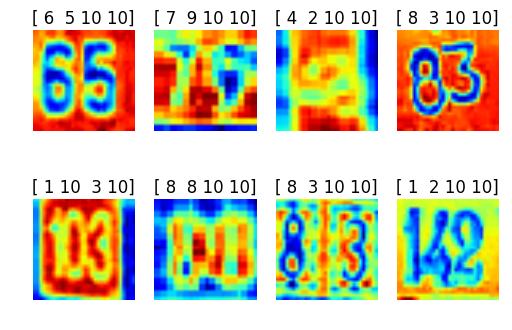

In [332]:
disp_sample_dataset(train_dataset, train_labels)

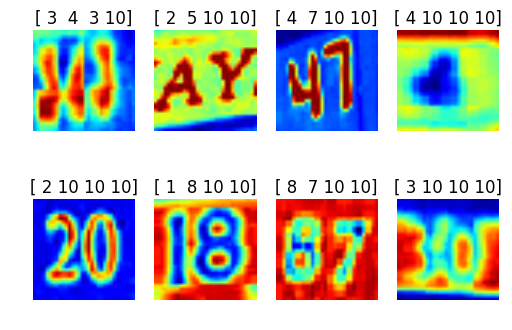

In [333]:
disp_sample_dataset(test_dataset, test_labels)

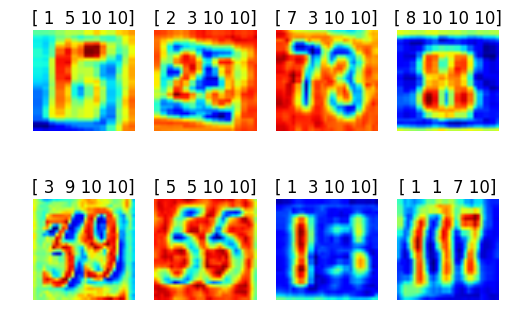

In [334]:
disp_sample_dataset(valid_dataset, valid_labels)

In [335]:
pickle_file = 'SVHN_multi_crop.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise